# **ANALYSIS NOTEBOOK**

In [1]:
!pip install pingouin

In [2]:
scores = "non_clipped"

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
 
from scipy.stats import ttest_ind
from scipy.stats import pearsonr, norm
import pingouin as pg
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.colors as mcolors

# **Data**

In [4]:
# import EMI data
df_all = pd.read_csv(f"../../data/analysis_data/df_all_{scores}.csv")

# rename
df_all = df_all.rename(columns = {"predictions_prob_disagree" : 'prob_disagree'})
df_all

/tmp/ipykernel_1942/3018109309.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(f"../../data/analysis_data/df_all_{scores}.csv")


,msg_id_parent,msg_id_child,submission_id,subreddit,exact_time_child,author_child,author_parent,author_submission,finetuned_child_E_norm,finetuned_child_I_norm,...,finetuned_parent_len_norm_z_trans_EMI,finetuned_child_len_norm_z_trans_EMI,finetuned_submission_len_norm_z_trans_EMI,self_parent_len_norm_z_trans_EMI,self_child_len_norm_z_trans_EMI,self_submission_len_norm_z_trans_EMI,predictions_label_ft,predictions_score_ft,prob_disagree,predictions_ft
0,c7ecp8d,c7ecs2n,14m325,Ask_Politics,1355166551.0,karmanaut,Ramblin_Dash,karmanaut,0.053025,0.072843,...,0.514532,-0.116730,0.594431,0.624110,-0.011457,0.172262,0,0.6180,0.38180,no_disagreement
1,c7ecp8d,c7ecxpk,14m325,Ask_Politics,1355167049.0,zoolander951,Ramblin_Dash,karmanaut,0.040605,0.001874,...,0.514532,0.363800,0.594431,0.624110,0.012864,0.172262,0,0.7134,0.28640,no_disagreement
2,c7ecp8d,c7eflag,14m325,Ask_Politics,1355175187.0,zossima,Ramblin_Dash,karmanaut,0.037034,-0.026841,...,0.514532,0.571814,0.594431,0.624110,0.600814,0.172262,0,0.6580,0.34180,no_disagreement
3,c7efx8q,c7ejh1d,14m325,Ask_Politics,1355187644.0,fathermocker,senatorskeletor,karmanaut,0.046751,0.040446,...,0.269966,0.096978,0.594431,0.130100,0.070296,0.172262,1,0.9507,0.95070,disagree
4,c7efx8q,c7f8140,14m325,Ask_Politics,1355286254.0,PKMKII,senatorskeletor,karmanaut,0.029991,-0.043360,...,0.269966,0.644853,0.594431,0.130100,0.612353,0.172262,0,0.8580,0.14180,no_disagreement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4938799,kfkh5ib,kfmd52k,18uirzt,politics,1970-01-01 00:00:01.703977996,Knightforlife,freddiethebaer,optimalg,0.289315,0.222072,...,1.250681,0.671616,-0.580210,1.062374,0.498045,-0.857240,0,0.9550,0.04495,no_disagreement
4938800,kfklsb6,kforzbx,18uirzt,politics,1970-01-01 00:00:01.704023024,bakerfredricka,4blockhead,optimalg,0.192579,0.210383,...,1.367783,-0.043416,-0.580210,1.165189,-0.381238,-0.857240,0,0.9920,0.00774,no_disagreement
4938801,kfmq5kr,kfp6tzv,18uirzt,politics,1970-01-01 00:00:01.704032059,glassjar1,DoubleTFan,optimalg,0.078374,0.101258,...,-0.197753,-0.140261,-0.580210,0.242695,-0.122822,-0.857240,1,0.8500,0.85000,disagree
4938802,kfp3d4v,kfp8xh8,18uirzt,politics,1970-01-01 00:00:01.704033069,HaulinBoats,4blockhead,optimalg,0.137089,0.224533,...,0.600514,-0.617072,-0.580210,0.207855,-0.789836,-0.857240,0,0.9414,0.05875,no_disagreement


In [5]:
# some submissions have no ideology
interactions_all = pd.read_csv(f"../../data/analysis_data/interactions_ideology_{scores}.csv")
interactions_all = interactions_all.merge(df_all[['msg_id_child', 'prob_disagree']], how = "left", right_on = "msg_id_child", left_on = "msg_id_child")
print(len(interactions_all))
print("Nr. of interactions without submission ideology:", len(interactions_all[interactions_all["submission_partisan"].isnull()]))

interactions_all[interactions_all["submission_partisan"].isnull()]["author_submission"].value_counts().sort_values(ascending = False)[:10]


/tmp/ipykernel_1942/2567536413.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactions_all = pd.read_csv(f"../../data/analysis_data/interactions_ideology_{scores}.csv")


4933855
Nr. of interactions without submission ideology: 3306444


author_submission
politicsmoderatorbot    3289370
politicsmod               12423
automoderator               148
asapientllama               147
direction_dull              128
mmcdonald1442               122
teh_speedster789             84
burakbarannn                 82
ibphysicshl                  52
lastfall                     48
Name: count, dtype: int64

In [6]:
# share of moderators among missing submission-ideology score
(3289370 + 12423 + 148) / len(interactions_all[interactions_all["submission_partisan"].isnull()])

0.9986381139375111

* three moderators out of 722 authors with missing ideology, accounting for 99.9% of the interactions
* $\to$ discard other missing ideologies

In [7]:
# incl mods
interactions_all = pd.read_csv(f"../../data/analysis_data/interactions_ideology_{scores}.csv")
interactions_all = interactions_all.merge(df_all[['msg_id_child', 'prob_disagree']], how = "left", right_on = "msg_id_child", left_on = "msg_id_child")
# add a dummy variable, indicating moderator submissions
interactions_all["Mod_Dummy"] = np.where(interactions_all["author_submission"].isin(["politicsmoderatorbot", "politicsmod", "automoderator"]), 1, 0)
interactions_all["Mod_Dummy"].value_counts()
# drop empty submission ideology 
interactions_all = interactions_all[~(interactions_all['submission_partisan'].isna() & (interactions_all['Mod_Dummy'] == 0))]

# Mods
mod_interactions = interactions_all[interactions_all["author_submission"].isin(["politicsmoderatorbot", "politicsmod", "automoderator"])]

# Human only: full because I have full scores for all three authors
interactions = pd.read_csv(f"../../data/analysis_data/full_interactions_ideology_{scores}.csv")
interactions = interactions.merge(df_all[['msg_id_child', 'prob_disagree']], how = "left", right_on = "msg_id_child", left_on = "msg_id_child")


# rename
interactions = interactions.rename(columns = {"predictions_label_ft" :'disagreement_label'}) 
mod_interactions = mod_interactions.rename(columns = {"predictions_label_ft" :'disagreement_label'}) 
interactions_all = interactions_all.rename(columns = {"predictions_label_ft" :'disagreement_label'}) 


/tmp/ipykernel_1942/1211899231.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactions_all = pd.read_csv(f"../../data/analysis_data/interactions_ideology_{scores}.csv")
/tmp/ipykernel_1942/1211899231.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactions = pd.read_csv(f"../../data/analysis_data/full_interactions_ideology_{scores}.csv")


## **8.1 Subreddit Shares of Interactions**

In [26]:
def get_counts_and_shares(df, column):
    return df[column].value_counts().to_frame('Count').join(df[column].value_counts(normalize=True).to_frame('%')).reset_index()


print("Share of Interactions by Subreddit")
interactions_subr = get_counts_and_shares(interactions_all, "subreddit")
interactions_subr

Share of Interactions by Subreddit


,subreddit,Count,%
0,politics,4164459,0.844829
1,PoliticalDiscussion,655653,0.133010
2,Ask_Politics,52308,0.010612
3,NeutralPolitics,42308,0.008583
4,PoliticalDebate,8454,0.001715
5,Askpolitics,6170,0.001252


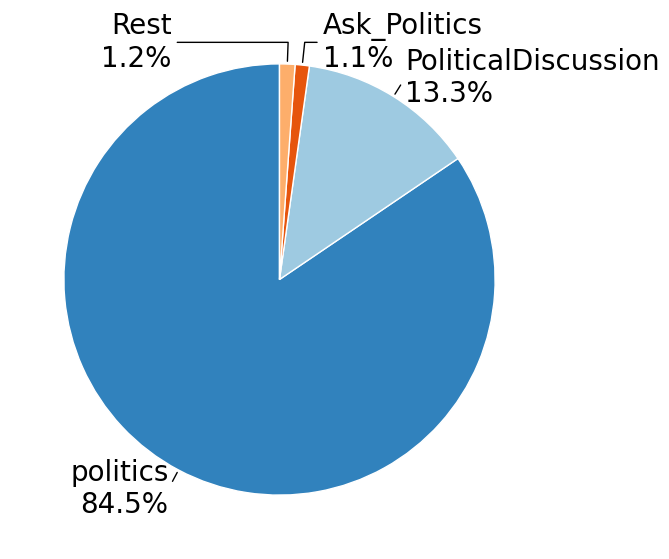

In [12]:


# combine small subreddits, to enhance plot visibility
def collapse_small_categories(df, label_col='subreddit', value_col='%', threshold=0.01):
    small = df[df[value_col] < threshold]
    large = df[df[value_col] >= threshold]
    if not small.empty:
        other = pd.DataFrame({
            label_col: ['Rest'],
            value_col: [small[value_col].sum()]
        })
        df = pd.concat([large, other], ignore_index=True)
    return df
interactions_clean = collapse_small_categories(interactions_subr.copy(), threshold=0.01)


# subreddits and color mapping
subreddits = list(interactions_clean['subreddit'])
colors = plt.get_cmap('tab20c')(range(0, 2 * len(subreddits), 2))



fig, ax = plt.subplots(figsize=(14, 7))
ax.set_aspect('equal')

# adjustment of annotations
sub_df = interactions_clean.copy().reset_index(drop=True)
# largets and smalles two
largest_idx = sub_df['%'].nlargest(2).index
smallest_idx = sub_df['%'].nsmallest(2).index

# pie with no labels
wedges, _ = ax.pie(
    sub_df['%'],
    labels=None,
    colors=colors[:len(sub_df)],
    startangle=90,
    wedgeprops=dict(edgecolor='white')
)

# manual positions for smallest slices
manual_positions = {
    smallest_idx[0]: (.2, 1.1),  
    smallest_idx[1]: (-.5, 1.1)
}


# annotate others
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2.0 + p.theta1
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))

    if i in smallest_idx:
        text_x, text_y = manual_positions[i]
        ha = 'left' if text_x > 0 else 'right'
    elif i in largest_idx:
        text_x, text_y = 1.1 * x, 1.1 * y
        ha = 'left' if x > 0 else 'right'
    else:
        text_x, text_y = 1.35 * x, 1.35 * y
        ha = 'left' if x > 0 else 'right'
    ax.annotate(
        f"{sub_df.loc[i, 'subreddit']}\n{sub_df.loc[i, '%']*100:.1f}%",
        xy=(x, y),
        xytext=(text_x, text_y),
        ha=ha,
        va='center',
        fontsize=20,
        arrowprops=dict(
            arrowstyle='-',
            connectionstyle=f"angle,angleA=0,angleB={ang}",
            lw=1
        )
    )


plt.savefig(
    "plots/Interactions_Shares_Subreddit.pdf",
    bbox_inches='tight',
    pad_inches=0.05
)


## **8.1 Subreddit Shares of Submissions**

In [27]:
print("Share of Submissions by Subreddit")
submissions_subr = get_counts_and_shares(interactions_all.drop_duplicates(subset = "submission_id"), "subreddit")
submissions_subr

Share of Submissions by Subreddit


,subreddit,Count,%
0,PoliticalDiscussion,38476,0.384107
1,politics,37724,0.376600
2,Ask_Politics,16083,0.160557
3,NeutralPolitics,4412,0.044045
4,Askpolitics,2862,0.028571
5,PoliticalDebate,613,0.006120


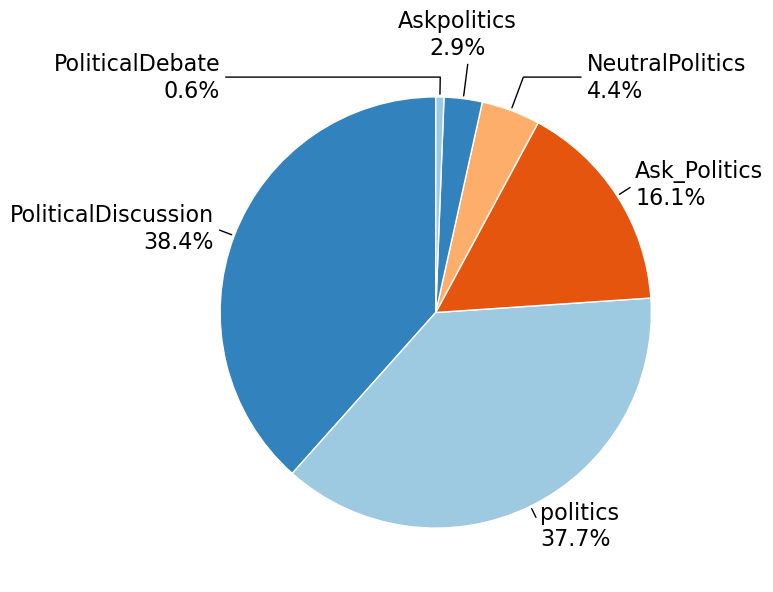

In [17]:
# subreddits and color mapping
subreddits = list(interactions_clean['subreddit'])
colors = plt.get_cmap('tab20c')(range(0, 2 * len(subreddits), 2))

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_aspect('equal')

sub_df = submissions_subr.copy().reset_index(drop=True)

# sort and get top 3
largest_idx = sub_df['%'].nlargest(3).index
small_slices = [i for i in range(len(sub_df)) if i not in largest_idx]

wedges, _ = ax.pie(
    sub_df['%'],
    labels=None,  
    colors=colors[:len(sub_df)],
    startangle=90,
    wedgeprops=dict(edgecolor='white')
)

# manual labels for smallest
positions = {
    "left":  (-1, 1),
    "center": (0.1, 1.2),
    "right": (0.7, 1)
}
pos_keys = ["right", "center", "left"]

# annotate smallest
for i, slice_idx in enumerate(small_slices):
    p = wedges[slice_idx]
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))
    pos_key = pos_keys[i % len(pos_keys)]
    text_x, text_y = positions[pos_key]
    ax.annotate(
        f"{sub_df.loc[slice_idx, 'subreddit']}\n{sub_df.loc[slice_idx, '%']*100:.1f}%",
        xy=(x, y),
        xytext=(text_x, text_y),
        ha='center' if pos_key == "center" else ('left' if pos_key == "right" else 'right'),
        fontsize=16,
        arrowprops=dict(arrowstyle='-', connectionstyle=f"angle,angleA=0,angleB={ang}", lw=1)
    )

# annotate largets
for slice_idx in largest_idx:
    p = wedges[slice_idx]
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))
    label_distance = 1.1
    text_x = label_distance * x
    text_y = label_distance * y

    ax.annotate(
        f"{sub_df.loc[slice_idx, 'subreddit']}\n{sub_df.loc[slice_idx, '%']*100:.1f}%",
        xy=(x, y),
        xytext=(text_x, text_y),
        ha='left' if x > 0 else 'right',
        va='center',
        fontsize=16,
        arrowprops=dict(arrowstyle='-', connectionstyle=f"angle,angleA=0,angleB={ang}", lw=1)
    )

plt.savefig(
    "plots/Submission_Shares_Subreddit.pdf",
    bbox_inches='tight',
    pad_inches=0.05
)


## **Disagreement Shares by Subreddit**

In [ ]:
subreddit_summary = (
    interactions
    .groupby('subreddit')
    .agg(disagreement_share=('disagreement_label', 'mean'),
         count=('disagreement_label', 'count'))
    .reset_index()
)
subreddit_summary.sort_values('disagreement_share', ascending=False)

## **8.2 Mod versus Human Started Discussions**

In [28]:
# share of moderated interactions per subreddit
mod_counts = (
    interactions_all[interactions_all['Mod_Dummy'] == 1]
    .groupby('subreddit')
    .size()
    .to_frame('Mod_Count')
)

# merge mod counts into overall table and get shares
interactions_subr = interactions_subr.merge(mod_counts, on='subreddit', how='left')
interactions_subr['Mod_Count'] = interactions_subr['Mod_Count'].fillna(0).astype(int)
interactions_subr['Mod_Share_in_Subreddit'] = interactions_subr['Mod_Count'] / interactions_subr['Count']

# overall mod interaction share
overall_mod_share = interactions_subr['Mod_Count'].sum() / interactions_subr['Count'].sum()
print(f"Overall Mod Interaction Share: {overall_mod_share:.2%}")

interactions_subr

Overall Mod Interaction Share: 66.99%


,subreddit,Count,%,Mod_Count,Mod_Share_in_Subreddit
0,politics,4164459,0.844829,3301841,0.792862
1,PoliticalDiscussion,655653,0.133010,0,0.000000
2,Ask_Politics,52308,0.010612,71,0.001357
3,NeutralPolitics,42308,0.008583,0,0.000000
4,PoliticalDebate,8454,0.001715,29,0.003430
5,Askpolitics,6170,0.001252,0,0.000000


In [29]:

# add share of mod submissions
mod_counts = (
    interactions_all.drop_duplicates(subset = "submission_id")[interactions_all['Mod_Dummy'] == 1]
    .groupby('subreddit')
    .size()
    .to_frame('Mod_Count')
)

submissions_subr = submissions_subr.merge(mod_counts, on='subreddit', how='left')
submissions_subr['Mod_Count'] = submissions_subr['Mod_Count'].fillna(0).astype(int)
submissions_subr['Mod_Share_in_Subreddit'] = submissions_subr['Mod_Count'] / submissions_subr['Count']

# overall mod shareof submissions
overall_mod_share = submissions_subr['Mod_Count'].sum() / submissions_subr['Count'].sum()
print(f"Overall Mod Submission Share: {overall_mod_share:.2%}")

submissions_subr

Overall Mod Submission Share: 1.41%


/tmp/ipykernel_1942/3409279945.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  interactions_all.drop_duplicates(subset = "submission_id")[interactions_all['Mod_Dummy'] == 1]


,subreddit,Count,%,Mod_Count,Mod_Share_in_Subreddit
0,PoliticalDiscussion,38476,0.384107,0,0.000000
1,politics,37724,0.376600,1373,0.036396
2,Ask_Politics,16083,0.160557,33,0.002052
3,NeutralPolitics,4412,0.044045,0,0.000000
4,Askpolitics,2862,0.028571,0,0.000000
5,PoliticalDebate,613,0.006120,4,0.006525


In [30]:
# group by mod and id
submission_level = (
    interactions_all
    .groupby(['submission_id', 'Mod_Dummy'])
    .agg(
        num_comments=('msg_id_parent', pd.Series.nunique),
        num_replies=('msg_id_child', pd.Series.nunique)
    )
    .reset_index()
)

# now group by mod
mean_counts_by_mod = (
    submission_level
    .groupby('Mod_Dummy')
    .agg(
        num_submissions=('submission_id', 'count'),  
        mean_comments=('num_comments', 'mean'),
        mean_replies=('num_replies', 'mean')
    )
    .rename(index={0: 'Human', 1: 'Moderator'})
    .T  # Transpose for nice display
)

mean_counts_by_mod

Mod_Dummy,Human,Moderator
num_submissions,98760.000000,1410.000000
mean_comments,8.124797,829.367376
mean_replies,16.478443,2341.802128


### **EMI Scores by Mods vs. Human**

In [31]:
def plot_EMI_grid(df, title="Distribution of EMI Scores", model = "finetuned", save = False, filepath = "plots/Distribution_EMI_Mod_noMod_finetuned.pdf"):


    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
    fig.suptitle(title, fontsize=16)

    row_labels = ['Human Started Discussions', 'Moderator Started Discussions']
    col_labels = ['Submission', 'Comment', 'Reply']
    text_types = ['submission', 'parent', 'child']
    
    total_submissions = df.drop_duplicates('submission_id').shape[0]
    total_interactions = df.drop_duplicates(['msg_id_parent', 'msg_id_child']).shape[0]

    for row_idx, mod_value in enumerate([0, 1]):  # 0 for unmoderated, 1 for moderated
        # Filter the dataframe for the current Mod_Dummy value
        filtered_df = df[df["Mod_Dummy"] == mod_value]

        # Ensure only unique messages per type
        unique_df = {
            "submission": filtered_df.drop_duplicates(subset="submission_id"),
            "parent": filtered_df.drop_duplicates(subset="msg_id_parent"),
            "child": filtered_df.drop_duplicates(subset="msg_id_child")
        }

        n_subs = unique_df["submission"].shape[0]
        subs_pct = n_subs / total_submissions * 100
    
        n_interactions = unique_df["child"].shape[0] 
        interactions_pct = n_interactions / total_interactions * 100

        for col_idx, text_type in enumerate(text_types):
            
            ax = axes[row_idx, col_idx]

            sns.kdeplot(data=unique_df[text_type][f"{model}_{text_type}_len_EMI_z_trans"], ax=ax, label='First EMI, then z-trans', color='steelblue', fill=True, alpha=0.5)
            sns.kdeplot(data=unique_df[text_type][f"{model}_{text_type}_len_norm_z_trans_EMI"], ax=ax, label='First z-trans, then EMI', color='salmon', fill=True, alpha=0.5)

           
            if row_idx == 0:
                ax.set_title(col_labels[col_idx], fontsize=14)
            if col_idx == 0:
                ax.set_ylabel(row_labels[row_idx], fontsize=12)

            if row_idx == 0 and col_idx == 2:
                ax.legend(loc='upper right')

            ax.grid(True)
            ax.set_xlabel("")
            
            if col_idx == 0:
                #text = f"{n_subs:,} ({subs_pct:.1f}%)\nof submissions\n\n"
                text = f"{subs_pct:.1f}%, (#{n_subs:})\nof submissions\n\n"
                #text += f"{n_interactions:,} ({interactions_pct:.1f}%)\nof interactions"
                text += f"{interactions_pct:.1f}%, (#{n_interactions:})\nof interactions"
                ax.text(0.95, 0.95, text,
                        transform=ax.transAxes,
                        ha='right', va='top',
                        fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
            

    # Common X label
    fig.text(0.5, -0.002, 'EMI Score', ha='center', fontsize=12)
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
    if save == True:
        plt.savefig(filepath)
    plt.show()


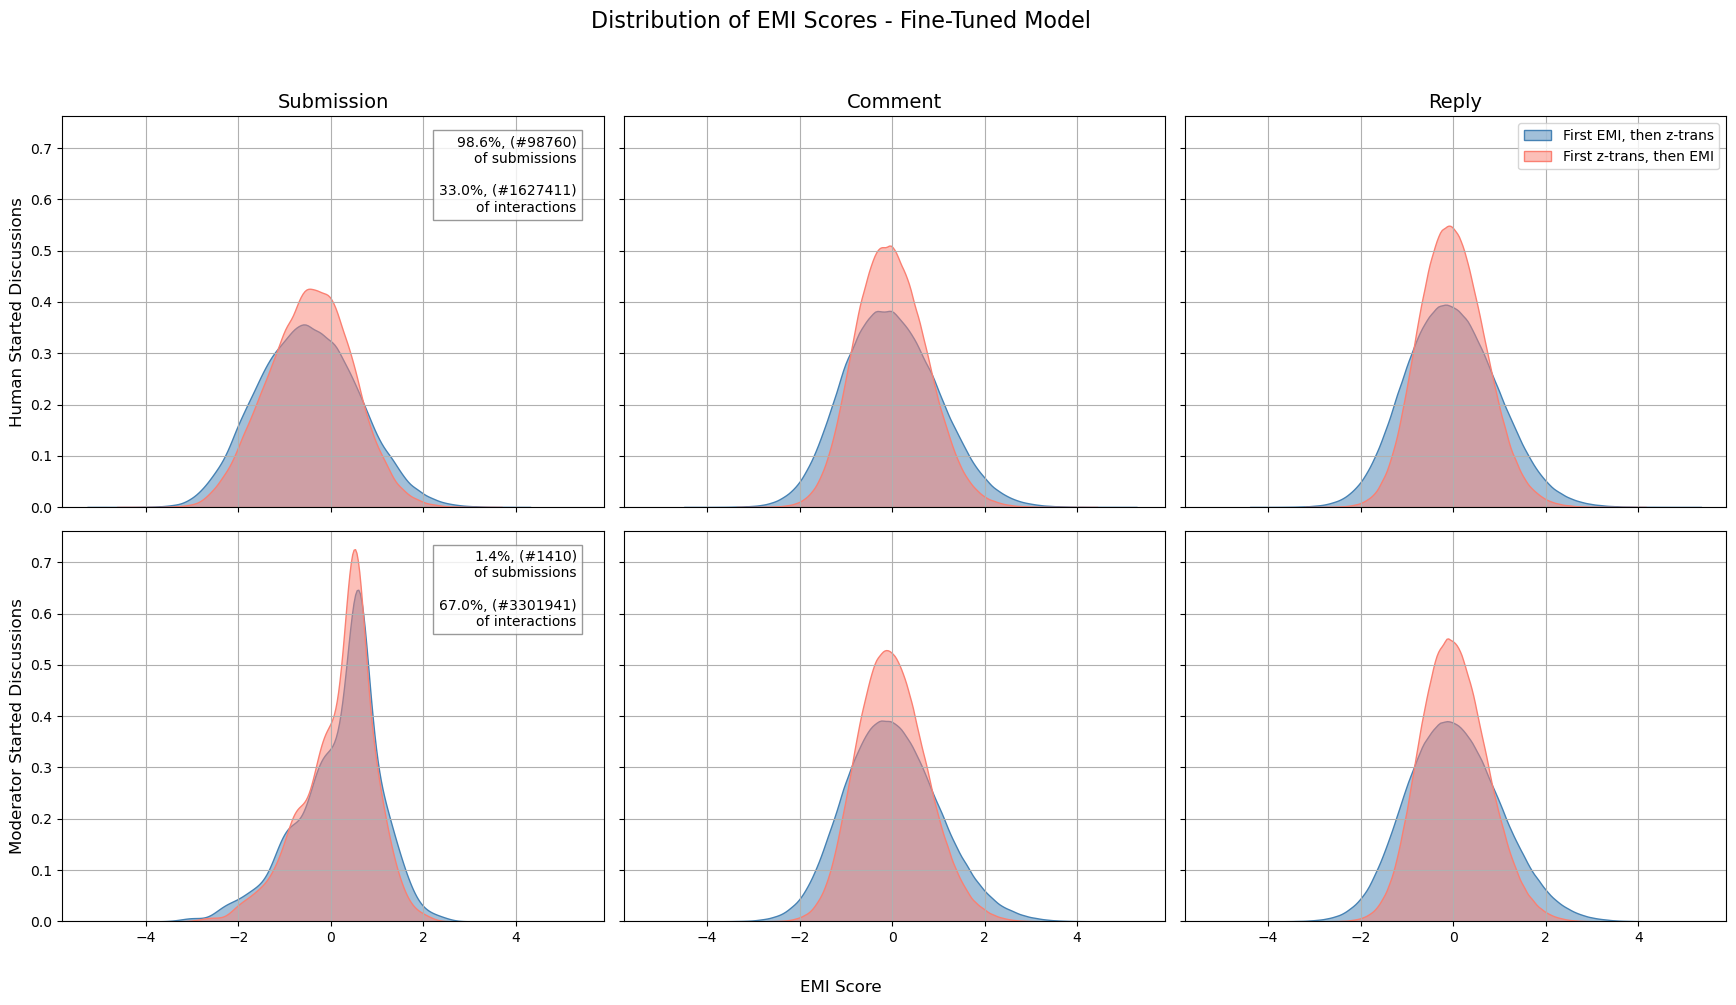

In [32]:
plot_EMI_grid(interactions_all, title = "Distribution of EMI Scores - Fine-Tuned Model", 
              model = "finetuned", save = True, 
              filepath = "plots/Distribution_EMI_Mod_noMod_finetuned.pdf")

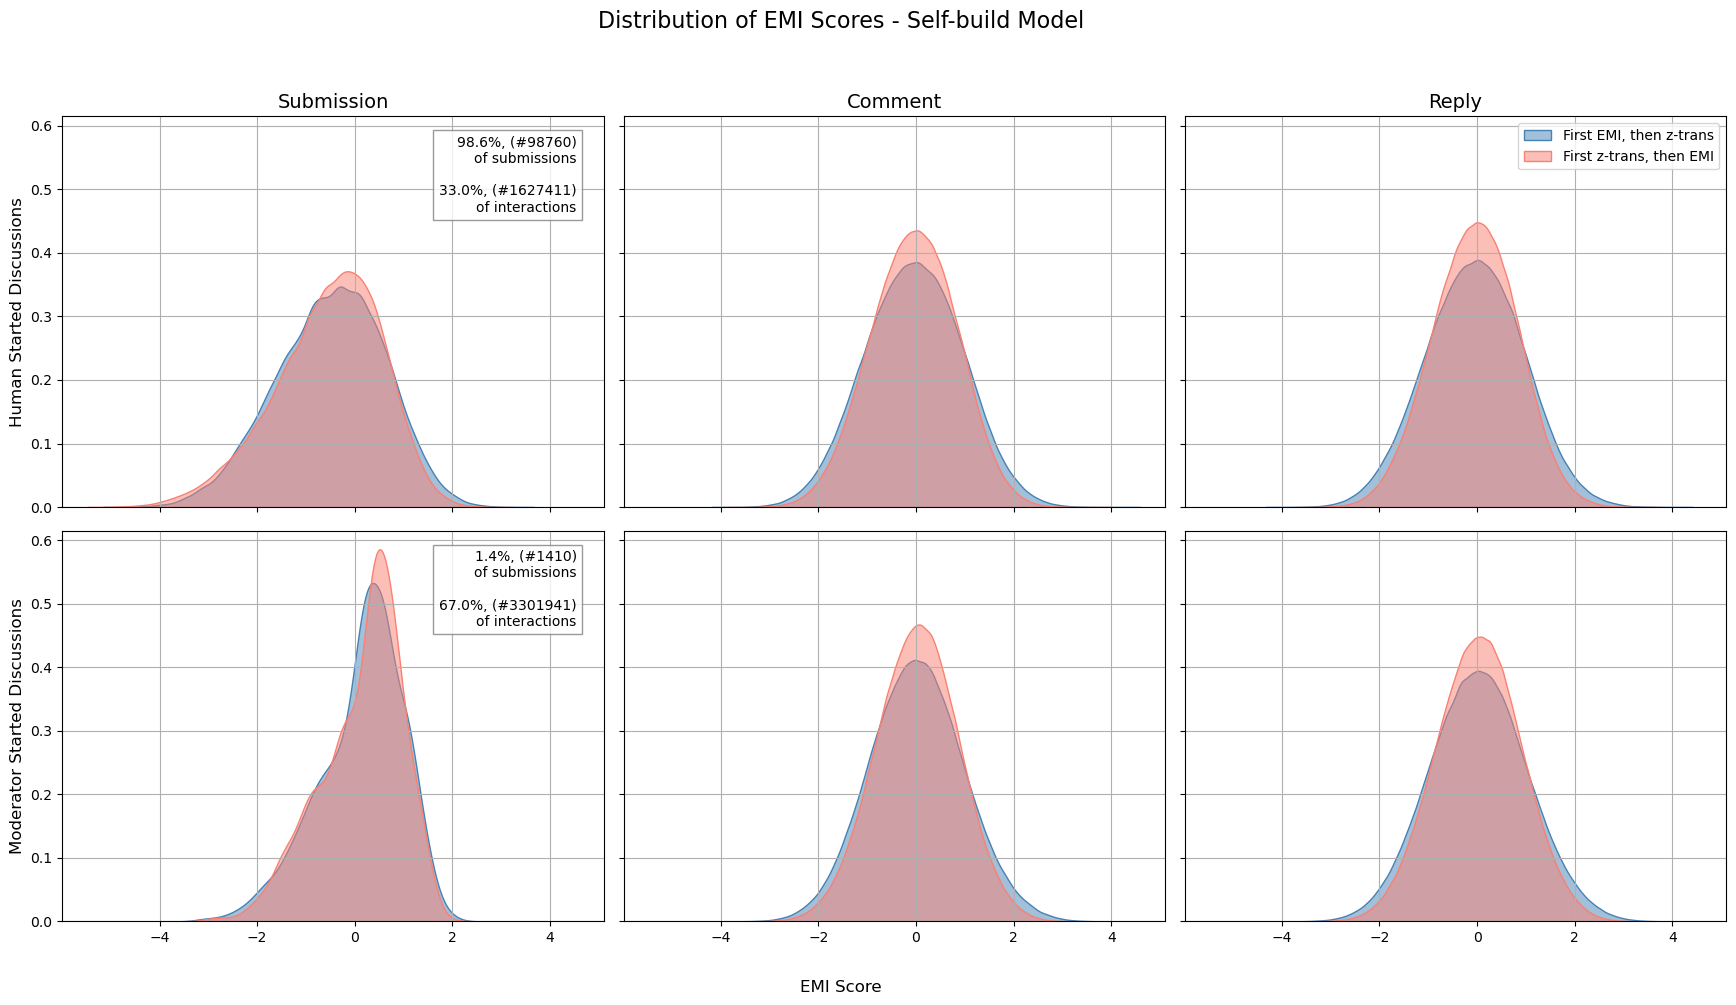

In [33]:
# robustness check on self build model
plot_EMI_grid(interactions_all, title = "Distribution of EMI Scores - Self-build Model", 
              model = "self", save = True, 
              filepath = "plots/Distribution_EMI_Mod_noMod_self.pdf")

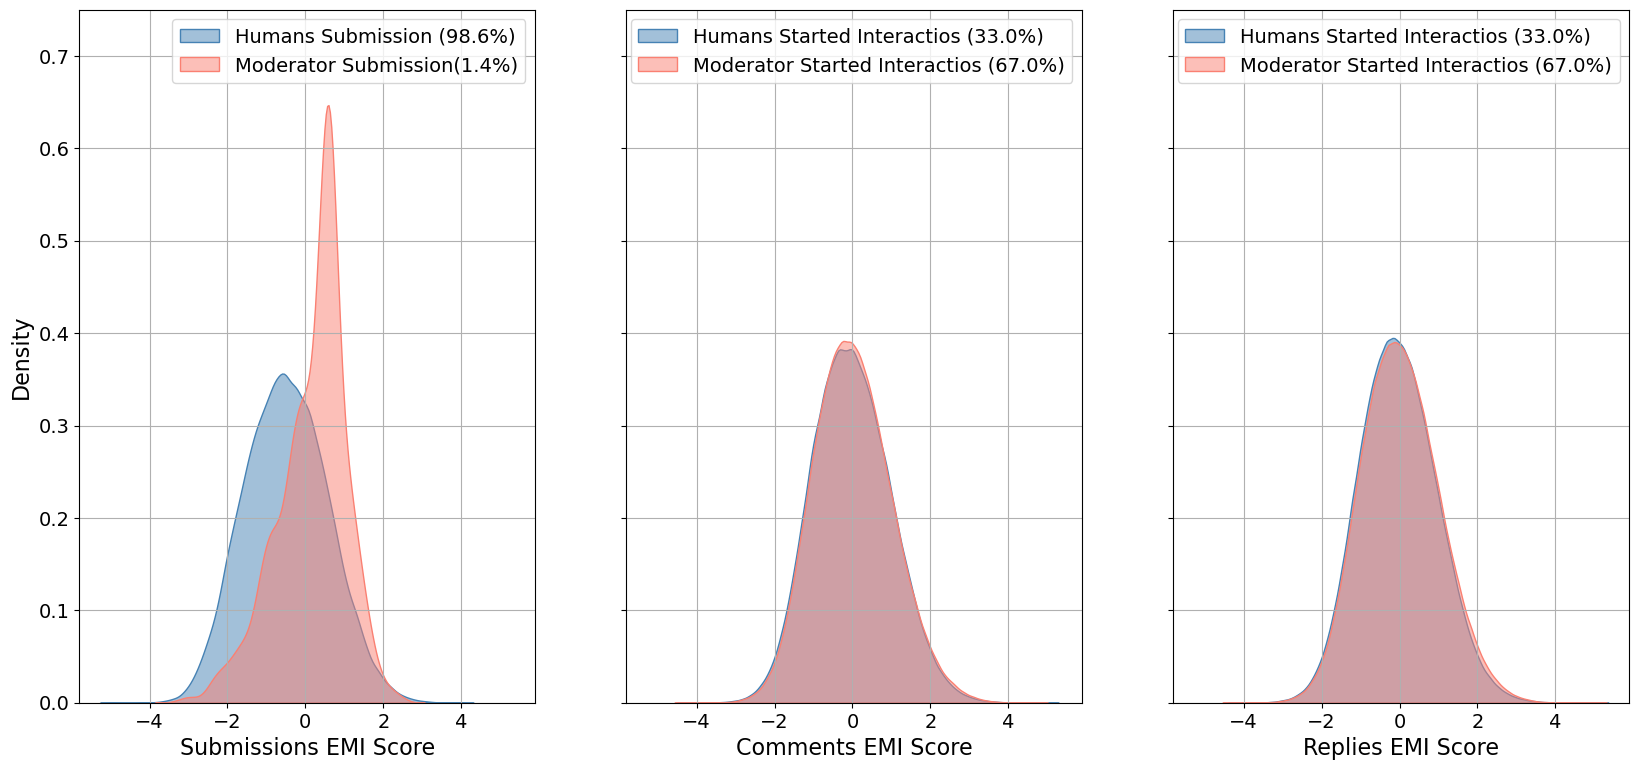

In [34]:
# moderators seem to be different --> closer look

fig, axes = plt.subplots(1, 3, figsize=(20, 9), sharex=True, sharey=True)

human_sub_share = (len(interactions_all[interactions_all["Mod_Dummy"] == 0].drop_duplicates(subset = "submission_id")) / len(interactions_all.drop_duplicates(subset = "submission_id"))) * 100
mod_sub_share = (len(interactions_all[interactions_all["Mod_Dummy"] == 1].drop_duplicates(subset = "submission_id")) / len(interactions_all.drop_duplicates(subset = "submission_id"))) * 100

human_interact_share = (len(interactions_all[interactions_all["Mod_Dummy"] == 0]) / len(interactions_all)) * 100
mod_interact_share = (len(interactions_all[interactions_all["Mod_Dummy"] == 1]) / len(interactions_all)) * 100

sns.kdeplot(data=interactions_all[interactions_all["Mod_Dummy"] == 0].drop_duplicates(subset = "submission_id")[f"finetuned_submission_len_EMI_z_trans"], ax = axes[0], label=f'Humans Submission ({human_sub_share:.1f}%)', color='steelblue', fill=True, alpha=0.5)
sns.kdeplot(data=interactions_all[interactions_all["Mod_Dummy"] == 1].drop_duplicates(subset = "submission_id")[f"finetuned_submission_len_EMI_z_trans"], ax = axes[0], label=f'Moderator Submission({mod_sub_share:.1f}%)', color='salmon', fill=True, alpha=0.5)

axes[0].set_xlabel("Submissions EMI Score", fontsize = 16)
axes[0].set_ylabel("Density", fontsize = 16)
axes[0].legend(fontsize = 14)
axes[0].grid(True)
axes[0].tick_params(axis='both', labelsize=14)
axes[0].set_ylim(0, 0.7)



sns.kdeplot(data=interactions_all[interactions_all["Mod_Dummy"] == 0].drop_duplicates(subset = "msg_id_parent")[f"finetuned_parent_len_EMI_z_trans"], ax = axes[1], label=f'Humans Started Interactios ({human_interact_share:.1f}%)', color='steelblue', fill=True, alpha=0.5)
sns.kdeplot(data=interactions_all[interactions_all["Mod_Dummy"] == 1].drop_duplicates(subset = "msg_id_parent")[f"finetuned_parent_len_EMI_z_trans"], ax = axes[1], label=f'Moderator Started Interactios ({mod_interact_share:.1f}%)', color='salmon', fill=True, alpha=0.5)

axes[1].set_xlabel("Comments EMI Score", fontsize = 16)
axes[1].set_ylabel("Density", fontsize = 16)
axes[1].legend(fontsize = 14)
axes[1].grid(True)
axes[1].tick_params(axis='both', labelsize=14)
axes[1].set_ylim(0, 0.7)


sns.kdeplot(data=interactions_all[interactions_all["Mod_Dummy"] == 0][f"finetuned_child_len_EMI_z_trans"], ax = axes[2], label=f'Humans Started Interactios ({human_interact_share:.1f}%)', color='steelblue', fill=True, alpha=0.5)
sns.kdeplot(data=interactions_all[interactions_all["Mod_Dummy"] == 1][f"finetuned_child_len_EMI_z_trans"], ax = axes[2], label=f'Moderator Started Interactios ({mod_interact_share:.1f}%)', color='salmon', fill=True, alpha=0.5)

axes[2].set_xlabel("Replies EMI Score", fontsize = 16)
axes[2].set_ylabel("Density", fontsize = 16)
axes[2].legend(fontsize = 14)
axes[2].grid(True)
axes[2].tick_params(axis='both', labelsize=14)
axes[2].set_ylim(0, 0.75)

plt.savefig("plots/Distribution_EMI_Human_Moderator.pdf", bbox_inches='tight')


In [35]:
print("SUBMISSIONS: \n------------")
print("Number of unique mod submissions", len(interactions_all[interactions_all["Mod_Dummy"] == 1].drop_duplicates(subset = "submission_id")))
print("Number of unique human submissions", len(interactions_all[interactions_all["Mod_Dummy"] == 0].drop_duplicates(subset = "submission_id")))

print("Share of Mod Submissions: ", len(interactions_all[interactions_all["Mod_Dummy"] == 1].drop_duplicates(subset = "submission_id")) / len(interactions_all.drop_duplicates(subset = "submission_id")))

SUBMISSIONS: 
------------
Number of unique mod submissions 1410
Number of unique human submissions 98760
Share of Mod Submissions:  0.014076070679844266


In [36]:
print("INTERACTIONS: \n------------")
print("Number of interactions, resulting from the", len(interactions_all[interactions_all["Mod_Dummy"] == 1].drop_duplicates(subset = "submission_id")),  "mod-started discussions", len(interactions_all[interactions_all["Mod_Dummy"] == 1]))
print("Number of interactions, resulting from the", len(interactions_all[interactions_all["Mod_Dummy"] == 0].drop_duplicates(subset = "submission_id")),  "human-started discussions", len(interactions_all[interactions_all["Mod_Dummy"] == 0]))

# share of interactions 
print("Share of Interactions by Mods", len(interactions_all[interactions_all["Mod_Dummy"] == 1]) / len(interactions_all))
print("Share of Interactions by Humans", len(interactions_all[interactions_all["Mod_Dummy"] == 0]) / len(interactions_all))

INTERACTIONS: 
------------
Number of interactions, resulting from the 1410 mod-started discussions 3301941
Number of interactions, resulting from the 98760 human-started discussions 1627411
Share of Interactions by Mods 0.6698529543031214
Share of Interactions by Humans 0.33014704569687864


**Interpretation**

* Few moderator submissions (#1410):
    * these 1410 submissions are a share of 1,5% of all submissions
    * but their share of interactions is 67%
 
* Human startes discussions (#98.760):
    * share of 98,5 %
    * their share of interactions is 33%
 
***

* EMI distribution of moderators is clearly different from the non-moderators
    * Mod Submission is way more evidence based speaking 
* EMI Score of Comment & replies EMI however is almost equal

## **Mods vs. Humans by Subreddit**

In [37]:
def plot_EMI_grid_subreddit(df, title="Distribution of EMI Scores", model = "finetuned", save = False, filepath = "plots/Distribution_EMI_by_Subr_finetuned.pdf"):


    fig, axes = plt.subplots(6, 3, figsize=(17, 17), sharex=True)
    axes = np.atleast_2d(axes)
    #fig.suptitle(title, fontsize=16)

    row_labels = ['politics', 'PoliticalDebate', 'Ask_Politics', 'Askpolitics', 'PoliticalDiscussion', 'NeutralPolitics']
    col_labels = ['Submission', 'Comment', 'Reply']
    text_types = ['submission', 'parent', 'child']
    #models = ['finetuned', 'self']

    for row_idx, subr in enumerate(row_labels):  # 0 for unmoderated, 1 for moderated
        # Filter the dataframe for the subreddit only
        filtered_df = df[df["subreddit"] == subr]

        filtered_df_human = filtered_df[filtered_df["Mod_Dummy"] == 0]
        filtered_df_mod = filtered_df[filtered_df["Mod_Dummy"] == 1]

        # Ensure only unique messages per type
        unique_df_human = {
            "submission": filtered_df_human.drop_duplicates(subset="submission_id"),
            "parent": filtered_df_human.drop_duplicates(subset="msg_id_parent"),
            "child": filtered_df_human.drop_duplicates(subset="msg_id_child")
        }

        unique_df_mod = {
            "submission": filtered_df_mod.drop_duplicates(subset="submission_id"),
            "parent": filtered_df_mod.drop_duplicates(subset="msg_id_parent"),
            "child": filtered_df_mod.drop_duplicates(subset="msg_id_child")
        }

        for col_idx, text_type in enumerate(text_types):
            
            ax = axes[row_idx, col_idx]
            ax.tick_params(axis='both', labelsize=16)

            sns.kdeplot(data=unique_df_human[text_type][f"{model}_{text_type}_len_EMI_z_trans"], ax=ax, label='Human', color='steelblue', fill=True, alpha=0.5)

            if len(unique_df_mod) > 0:
                sns.kdeplot(data=unique_df_mod[text_type][f"{model}_{text_type}_len_EMI_z_trans"], ax=ax, label='Moderator', color='salmon', fill=True, alpha=0.5)

            if row_idx == 0:
                ax.set_title(col_labels[col_idx], fontsize=18)
            if col_idx == 0:
                ax.set_ylabel(row_labels[row_idx], fontsize=18)
            if col_idx > 0:
                ax.set_ylabel("")

            if row_idx == 0 and col_idx == 2:
                ax.legend(loc='upper right', fontsize = 16)

            ax.grid(True)
            ax.set_xlabel("")
            

    # Common X label
    fig.text(0.5, -0.002, 'EMI Score', ha='center', fontsize=18)
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
    if save == True:
        plt.savefig(filepath)
    plt.show()



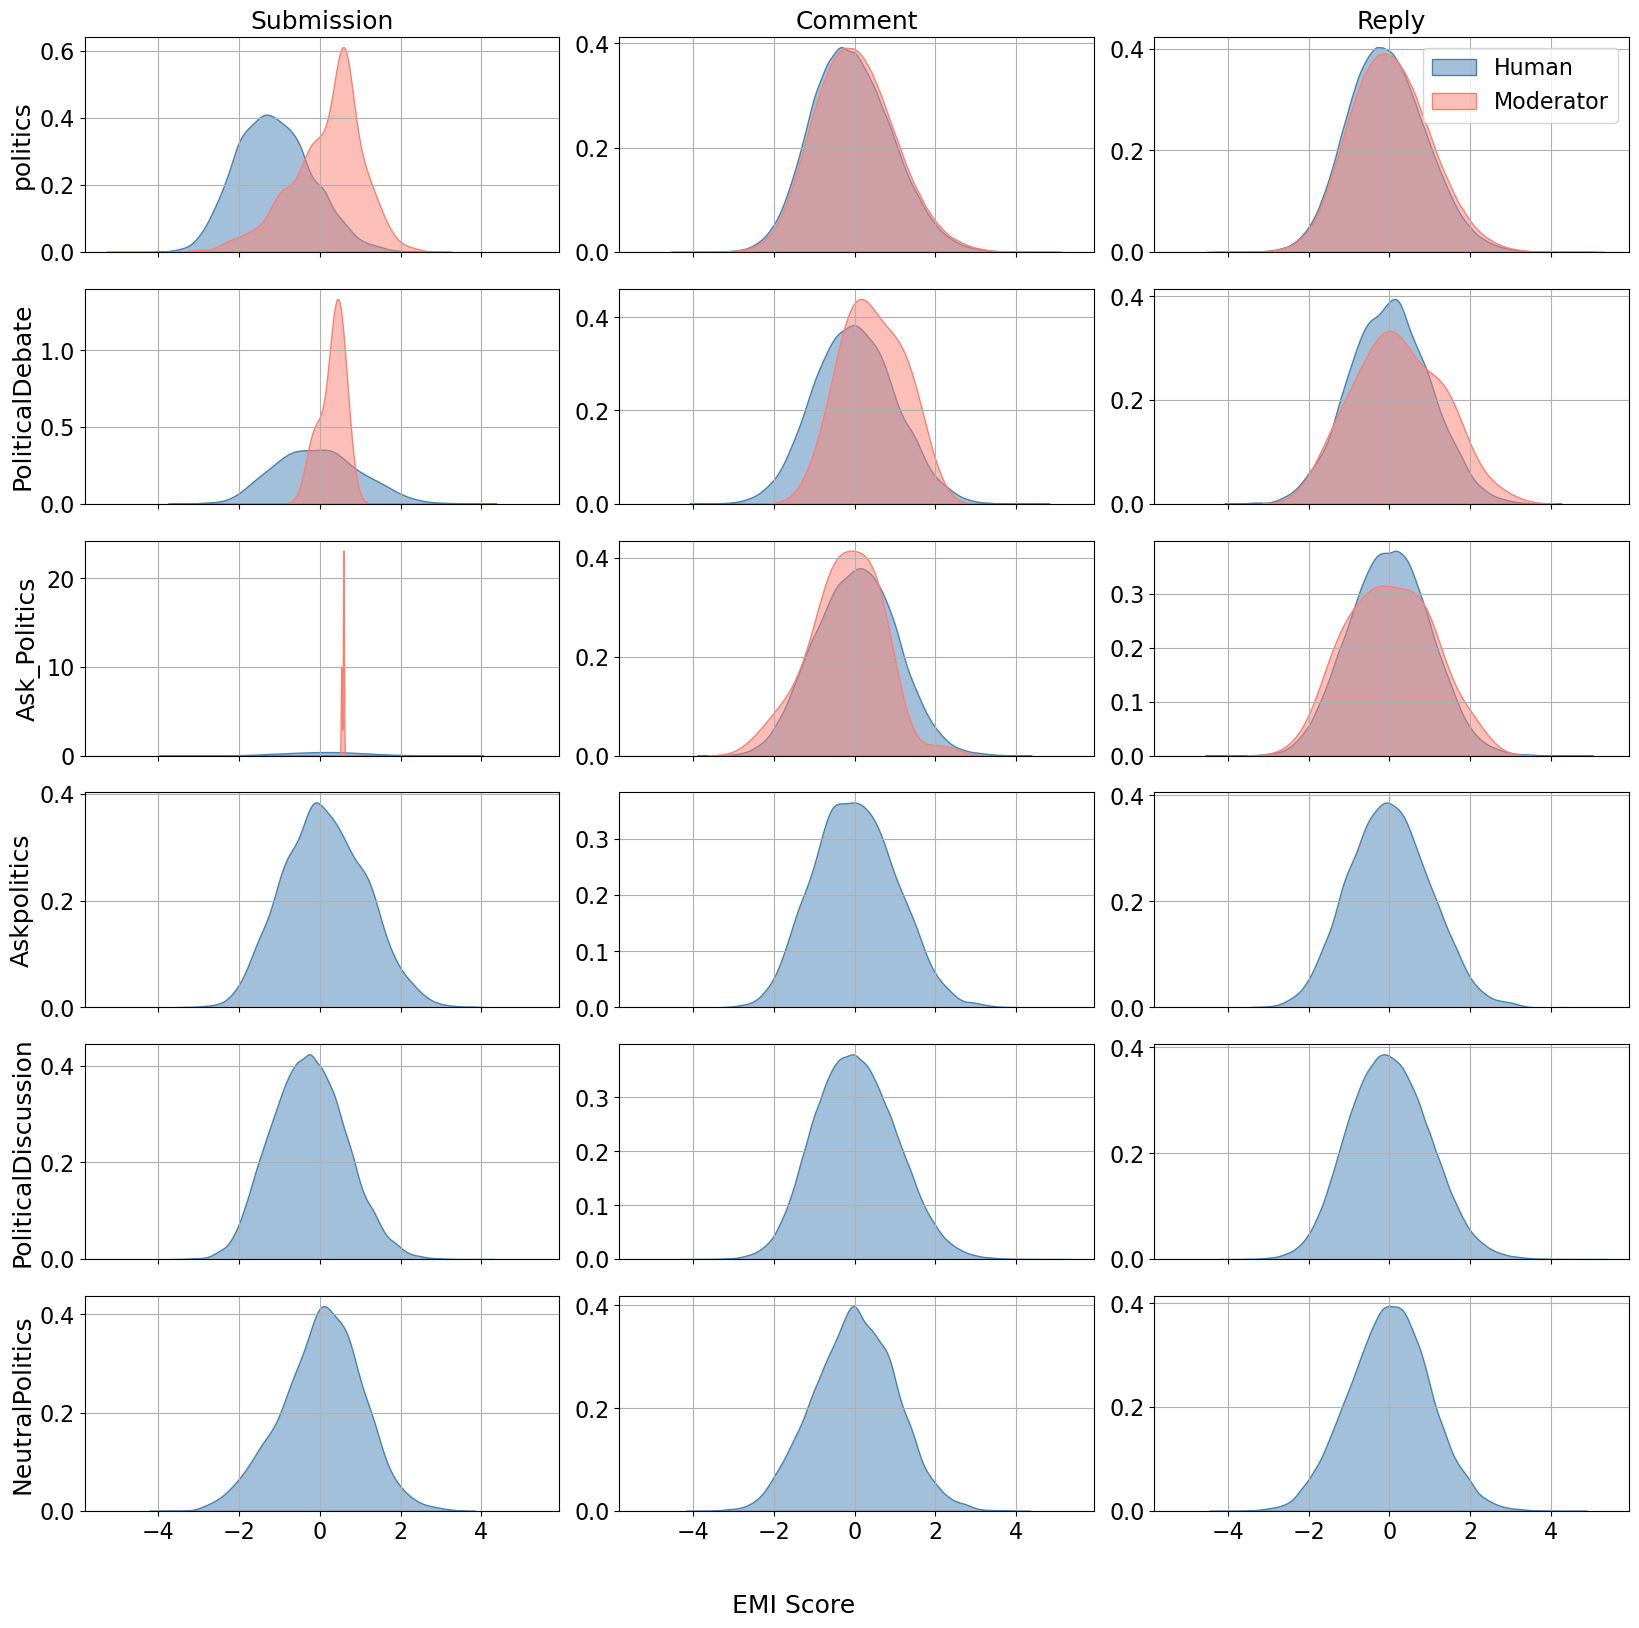

In [38]:
plot_EMI_grid_subreddit(interactions_all, title = "Distribution of EMI Scores per Subreddit\n Fine-tuned Model", 
                        model = "finetuned", save = True, 
                        filepath = "plots/Distribution_EMI_by_Subr_finetuned.pdf")

**Final Interpretation**

* Moderator started discussions are different that human started discussion
    * They are a few (1.5% of submissions are moderators), but they account for a huge share of interactions (67%)
    * Even more, at subreddit level: for politics 80% of interactions are below mod submissions, but mod submissions are only 3% of submissions
    * Their level of activenedd is was higher: 100 times more comments
* We see that mod submissions are way more E-speaking than human submissions
* Disrtibution of EMI in comments and replies of mod- vs. human interactions are the same

* Shares of disagreement are lower on mod started interactions

$\to$ treat mod discussions separately

$\to$ in model building, add mod dummy and potentially mod dummy interaction with subreddit and one with EMI (next step suggests: mod discussions: EMI more predictive of stance)